## Example CMB likelihood code

In [1]:
import matplotlib.pyplot as plt
from tools.cmb import CMB
import numpy as np

With the code we can build a likelihood function for the planck data and an estimate of the planck noise.

/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:79: RuntimeWarning: divide by zero encountered in divide
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l
/Users/harrybevins/Documents/Current-projects/cmb-likelihood/tools/cmb.py:79: RuntimeWarning: invalid value encountered in multiply
  cl *= (2*np.pi)/(np.arange(len(cl))*(np.arange(len(cl))+1)) # convert to C_l


(152.64020885522785, [])


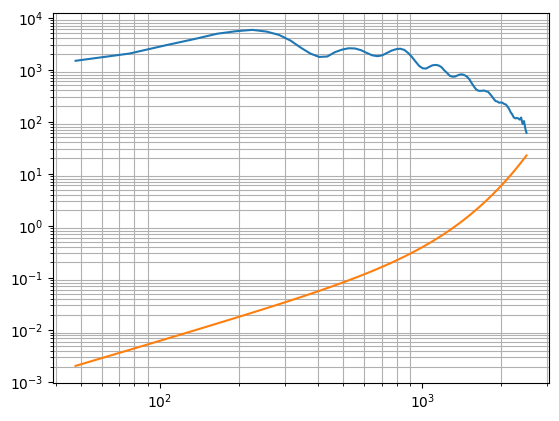

In [2]:
# the generator
cmb_generator = CMB()

# planck best fit paraemters
theta = [0.022, 0.12, 1.04, 0.06, 0.96, 3.0]
# get the planck data
planck, l, ps, ns = cmb_generator.get_planck()
# get an estimate of the planck instrument noise
noise = cmb_generator.get_planck_noise(l)

plt.plot(l, planck*(l*(l+1)/(2*np.pi)),label='Planck')
plt.plot(l, noise*(l*(l+1)/(2*np.pi)))
plt.loglog()
plt.grid(which='minor')

# build the likelihood function with planck data
likelihood = cmb_generator.get_likelihood(planck, l, noise)
# evaluate planck likelihood at the planck best fit parameters
print(likelihood(theta))


We can also calculate the theoretical model corresponding to Planck best fit parameters (using CAMB) and plot this.

Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

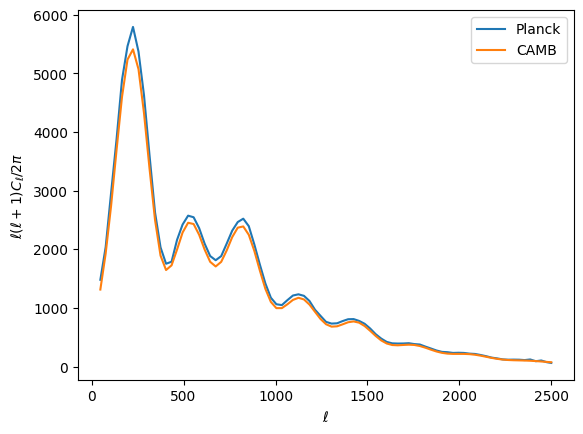

In [3]:
model = cmb_generator.get_camb_model(theta)
model = np.interp(l, np.arange(len(model)), model)

plt.plot(l, planck*(l*(l+1)/(2*np.pi)), label='Planck')
plt.plot(l, model*(l*(l+1)/(2*np.pi)), label='CAMB')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')


Next, we can generate a set of parameters from a prior distribution and evaluate their likelihoods with respect to the Planck data.

In [4]:
thetas = np.vstack([cmb_generator.prior(np.random.uniform(0, 1, 6)) for i in range(10)])
likelihoods = [likelihood(t) for t in thetas]
print(likelihoods)

[(-4206.386146880075, []), (-50787.463202526975, []), (-35809.822413526876, []), (-122321.84912555869, []), (-18969.08950586762, []), (-2299.7161606743116, []), (-145390.98113325352, []), (-196304.9246533673, []), (-2509.7131716810104, []), (-73691.68916634464, [])]


Finally we can generate noisy data. The function `get_samples` produces an observation of a theoretical signal with parameters `theta` from an instrument with `noise`.

(10, 83)
(10, 83)


Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

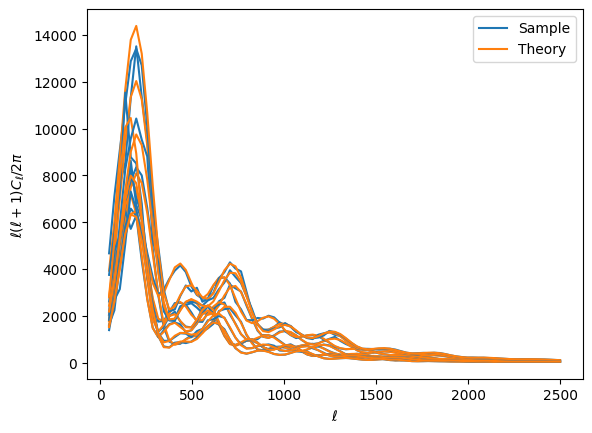

In [5]:
s = np.array([cmb_generator.get_samples(l, t, noise) for t in thetas])

theory = s[:, 0, :]
sample = s[:, 1, :]
print(theory.shape)
print(sample.shape)
for i in range(len(sample)):
    plt.plot(l, sample[i]*(l*(l+1)/(2*np.pi)), c='C0')
    plt.plot(l, theory[i]*(l*(l+1)/(2*np.pi)), c='C1')
plt.legend(['Sample', 'Theory'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')


Text(0, 0.5, '$\\ell(\\ell+1)N_\\ell/2\\pi$')

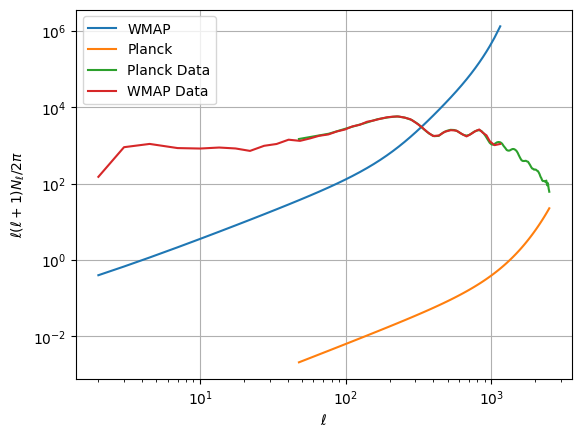

In [9]:
wmap_theta = np.array([0.82, 0.62, 0.49, 0.33, 0.21]) # in degrees
wmap_theta *= np.pi/180 # convert to radians

wmap_noise = np.array([0.8,	0.8, 1.0, 1.2, 1.6])
wmap_noise *= 1e3 # convert to microK
wmap_noise *= np.sqrt(np.pi/(180*3600))

# nine year binned wmap data
wmap = np.loadtxt('wmap_binned.txt')
lwmap = wmap[:, 0]

nis = []
for i in range(len(wmap_noise)):
    # from montepython code https://github.com/brinckmann/montepython_public/blob/3.6/montepython/likelihood_class.py#L1096
    ninst = wmap_noise[i]**-2 * \
        np.exp(-lwmap*(lwmap+1)*wmap_theta[i]**2/(8*np.log(2))) #one over ninst
    nis.append(ninst)
ninst = np.array(nis).T
ninst = np.sum(ninst, axis=1)
wnoise = 1/ninst
wnoise /= np.sqrt(2*lwmap + 1)

# nine year binned wmap data
wmap = np.loadtxt('wmap_binned.txt')

plt.plot(lwmap, wnoise*(lwmap*(lwmap+1)/(2*np.pi)), label='WMAP')
plt.plot(l, noise*(l*(l+1)/(2*np.pi)), label='Planck')
plt.plot(l, planck*(l*(l+1)/(2*np.pi)), label='Planck Data')
plt.plot(lwmap, wmap[:, 3], label='WMAP Data')
plt.legend()
plt.loglog()
plt.grid()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)N_\ell/2\pi$')



(10, 45)
(10, 45)


Text(0, 0.5, '$\\ell(\\ell+1)C_\\ell/2\\pi$')

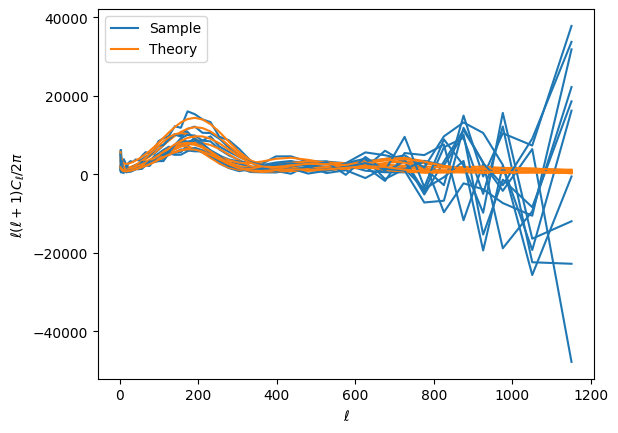

In [11]:
s = np.array([cmb_generator.get_samples(lwmap, t, wnoise) for t in thetas])

theory = s[:, 0, :]
sample = s[:, 1, :]
theory -= wnoise
sample -= wnoise
print(theory.shape)
print(sample.shape)
for i in range(len(sample)):
    plt.plot(lwmap, sample[i]*(lwmap*(lwmap+1)/(2*np.pi)), c='C0')
    plt.plot(lwmap, theory[i]*(lwmap*(lwmap+1)/(2*np.pi)), c='C1')
plt.legend(['Sample', 'Theory'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$')